<a href="https://colab.research.google.com/github/theshreyaraj/Analog-Clock-Shreya/blob/master/youtube_adview_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import time
import seaborn as sns
import joblib
import keras
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from google.colab import files

READ FILES


In [2]:
data_train=pd.read_csv("train.csv")
data_test=pd.read_csv("test.csv")

In [3]:
data_train

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D
...,...,...,...,...,...,...,...,...,...
14994,VID_31,2,525949,1137,83,86,2015-05-18,PT6M10S,A
14995,VID_5861,1,665673,3849,156,569,2015-10-20,PT3M56S,D
14996,VID_805,4,3479,16,1,1,2013-08-23,PT3M13S,B
14997,VID_19843,1,963,0,0,0,2010-10-02,PT26S,G


In [4]:
data_test

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B
...,...,...,...,...,...,...,...,...
8759,VID_2944,111205,471,14,101,2011-04-19,PT3M14S,C
8760,VID_8195,1074457,1024,195,65,2016-06-03,PT2H18M35S,D
8761,VID_18973,1891692,4606,1109,191,2016-06-26,PT7M14S,F
8762,VID_5849,714859,1639,151,382,2016-03-23,PT3M15S,D


PREPROCESSING

In [5]:
categories={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7,"H":8}

data_train["category"]=data_train["category"].map(categories)
data_test["category"]=data_test["category"].map(categories)

In [6]:
for e in ["views","likes","dislikes","comment"]:
  data_train=data_train[data_train[e]!='F']
  for i in range(len(data_test)):
    if data_test[e][i]=='F':
      data_test.loc[i,e]='0'

for e in ["views","likes","dislikes","comment","adview"]:
  data_train[e]=pd.to_numeric(data_train[e])
  if e!='adview':
    data_test[e]=pd.to_numeric(data_test[e])

  data_train=data_train[data_train["adview"]<2000000]

  data_train["published"]=LabelEncoder().fit_transform(data_train["published"])
  data_test["published"]=LabelEncoder().fit_transform(data_test["published"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
def checki(x):
  y=x[2:]
  h,m,s,mm="","","",""
  P=["H","M","S"]
  for i in y:
    if i not in P:
      mm += i
    else:
      if i==P[0]:
        h=mm
        mm=""
      elif i==P[1]:
        m=mm
        mm=""
      else:
        s=mm
        mm=""
    
  if h=="":
    h="00"
  if m=="":
    m="00"
  if s=="":
    s="00"
  bp=h+":"+m+":"+s
  return bp

In [9]:
def func_sec(time_str):
  h,m,s=time_str.split(":")
  return int(h) * 3600 + int(m) * 60 + int(s)

In [10]:
data_train["duration"]=data_train["duration"].apply(checki).apply(func_sec)
data_test["duration"]=data_test["duration"].apply(checki).apply(func_sec)

Visualize Correlation

[]

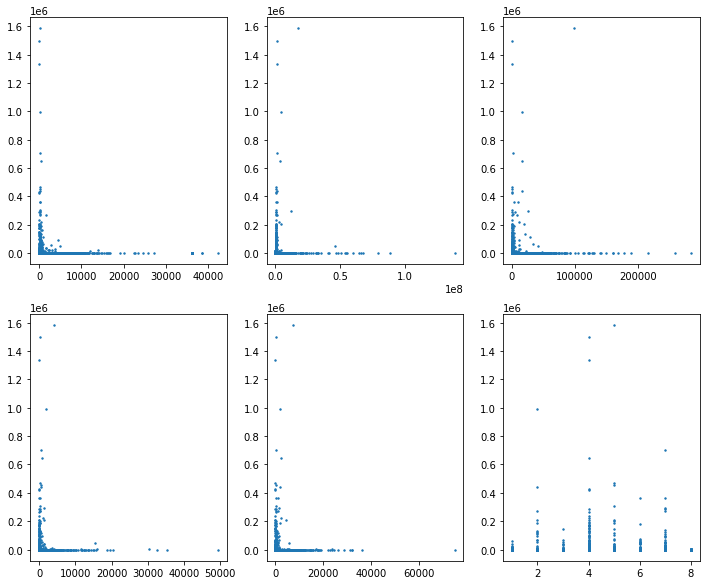

In [11]:
fig,axs=plt.subplots(2,3,figsize=(12,10))
axs[0,0].scatter(data_train["duration"],data_train["adview"],s=2)
axs[0,1].scatter(data_train["views"],data_train["adview"],s=2)
axs[0,2].scatter(data_train["likes"],data_train["adview"],s=2)
axs[1,0].scatter(data_train["dislikes"],data_train["adview"],s=2)
axs[1,1].scatter(data_train["comment"],data_train["adview"],s=2)
axs[1,2].scatter(data_train["category"],data_train["adview"],s=2)
plt.plot()

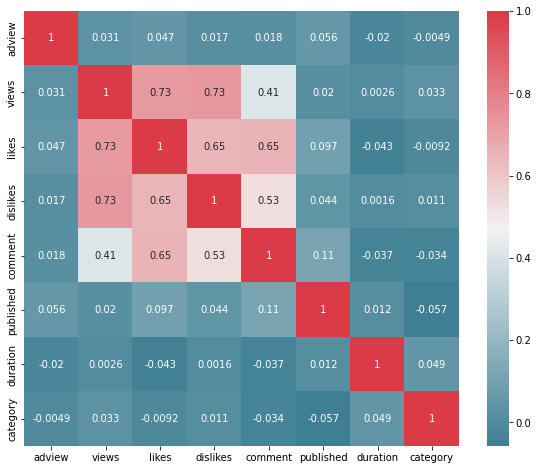

In [12]:
f,ax=plt.subplots(figsize=(10,8))
corr=data_train.corr()
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sns.diverging_palette(220,10,as_cmap=True),
            square=True,ax=ax,annot=True)
plt.show()

Prepare for input to model

In [13]:
Y=pd.DataFrame(data_train.iloc[:,1].values,columns=["target"])
data_test_y=pd.DataFrame(data_test.iloc[:,0].values,columns=["vidid"])
data_train=data_train.drop(["adview","vidid"],axis=1)
data_test=data_test.drop(["vidid"],axis=1)

In [14]:
X_train,X_test,y_train,y_test=train_test_split(
    data_train,Y,test_size=0.1,random_state=42
)

y_train=y_train.to_numpy().ravel()
y_test=y_test.to_numpy().ravel()

In [15]:
sc_X=MinMaxScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)
data_test=sc_X.transform(data_test)

Test on models

In [16]:
def evaluate(X_test,y_test,model):
  y_preds=model.predict(X_test)
  print("Mean Squared Error:",mean_squared_error(y_test,y_preds))
  print("R^2:",r2_score(y_test,y_preds))
  plt.figure(figsize=(16,8))
  plt.scatter(range(len(y_preds)),y_preds,color="red",s=1)
  plt.scatter(range(len(y_test)),y_test,color="green",s=1)
  plt.show()

Linear Regression

Linear Regression
Mean Squared Error: 104797222.51814939
R^2: -0.022721187595377


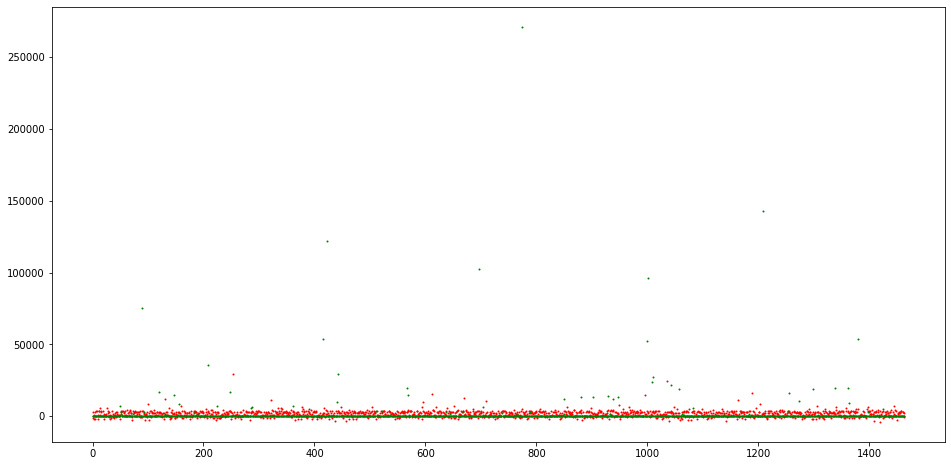

In [17]:
linear_regression=LinearRegression()
linear_regression.fit(X_train,y_train)
print("Linear Regression")
evaluate(X_test,y_test,linear_regression)

SVR

SVR
Mean Squared Error: 103562575.41575138
R^2: -0.010672206520453864


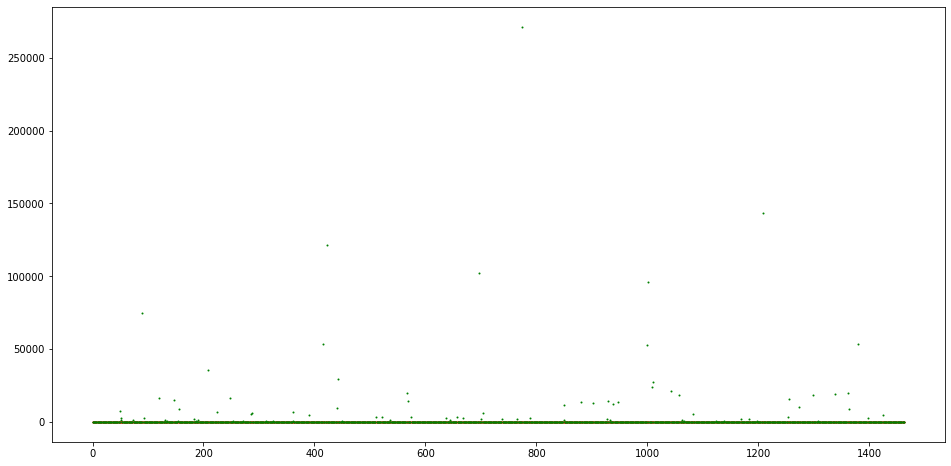

In [18]:
svr_model=SVR()
svr_model.fit(X_train,y_train)
print("SVR")
evaluate(X_test,y_test,svr_model)

Decision Tree

DECISION TREE
Mean Squared Error: 284921667.50956285
R^2: -1.780564400135411


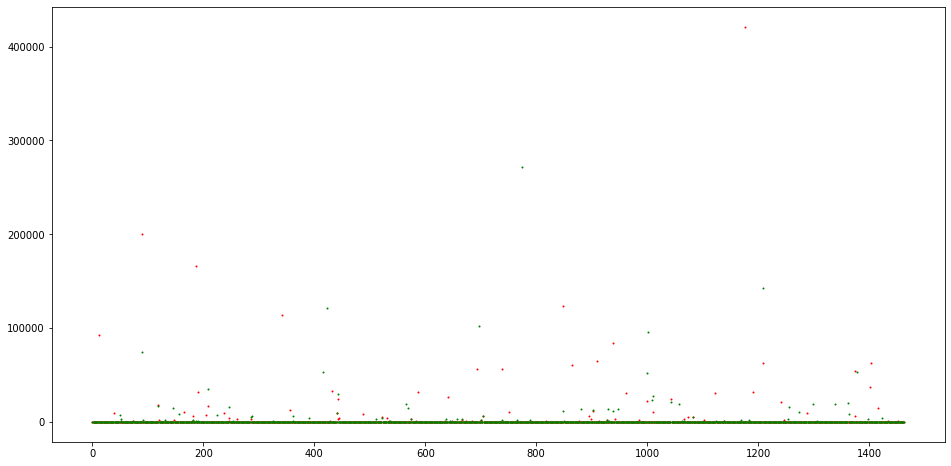

In [19]:
dt_model=DecisionTreeRegressor()
dt_model.fit(X_train,y_train)
print("DECISION TREE")
evaluate(X_test,y_test,dt_model)

RANDOM FOREST

RANDOM FOREST
Mean Squared Error: 235350570.5543032
R^2: -1.2967976558430356


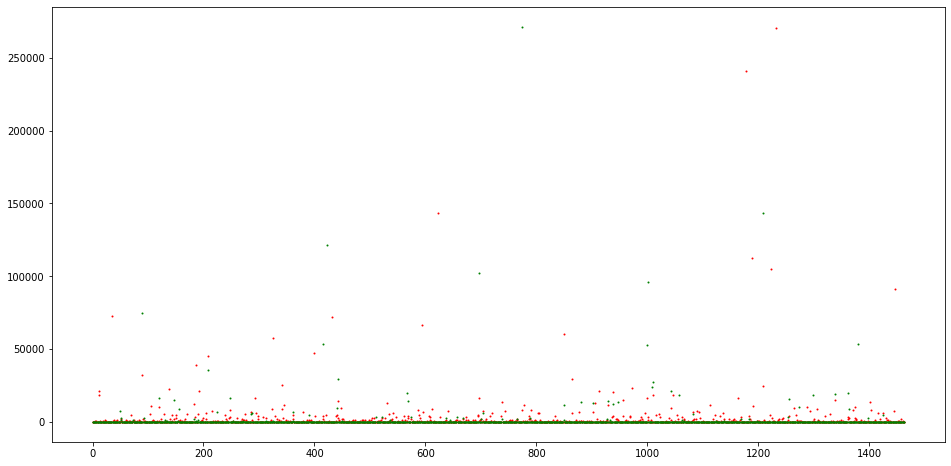

In [20]:
rf_model=RandomForestRegressor()
rf_model.fit(X_train,y_train)
print("RANDOM FOREST")
evaluate(X_test,y_test,rf_model)

Random Forest w/ Hyperparameter tuning

In [21]:
n_estimators=[int(x) for x in np.linspace(50,300,num=10)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(1,60,num=5)]
min_samples_split=[5,10]

random_grid={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split}

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mean Squared Error: 130241381.76735488
R^2: -0.2710319742691998


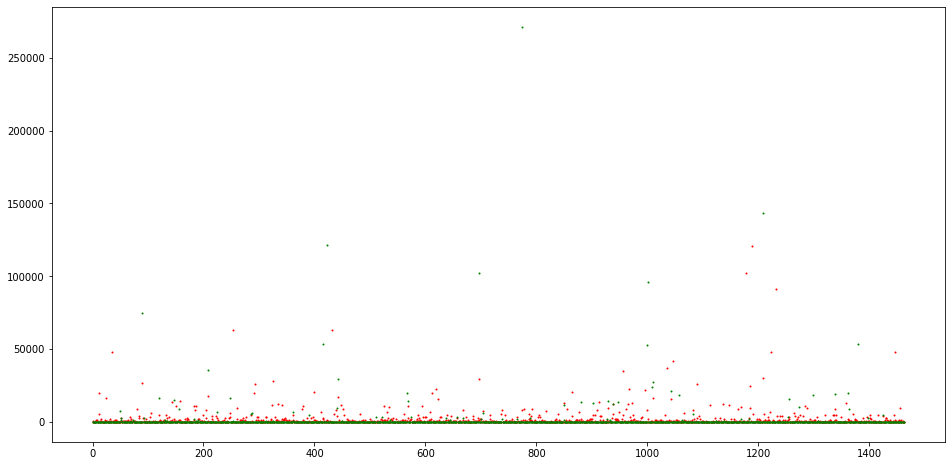

In [22]:
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions = random_grid, n_iter = 20, cv = 10, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
rf_random.fit(X_train, y_train)
evaluate(X_test, y_test, rf_random.best_estimator_)

NEURAL NETWORK

In [25]:
ann_model=keras.models.Sequential([
                                   keras.layers.Dense(16,activation='relu'),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(16,activation='relu'),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(8,activation='relu'),
                                   keras.layers.Dense(units=1)
])

In [26]:
ann_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])

Mean Squared Error: 101144292.5385856
R^2: 0.012927933603948949


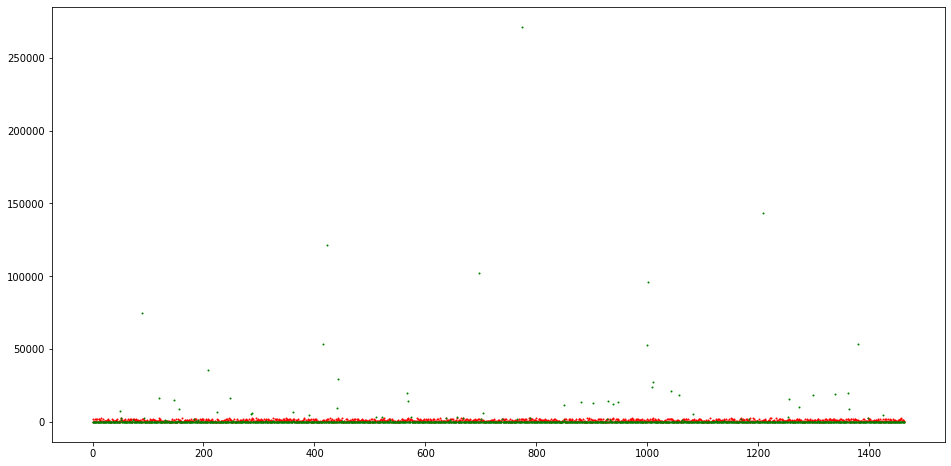

In [27]:
ann_model.fit(X_train,y_train,epochs=200,verbose=0)
evaluate(X_test,y_test,ann_model)

SAVE MODEL

In [28]:
joblib.dump(rf_random.best_estimator_,"ml_model.pkl")

['ml_model.pkl']

In [29]:
ann_model.save("ann_model.h5")

Load Model

In [30]:
model=joblib.load("ml_model.pkl")

In [31]:
model=keras.models.load_model("ann_model.h5")

In [32]:
preds=model.predict(data_test)
preds=preds.astype(np.int16)

In [33]:
preds=preds.reshape(1,-1)[0].tolist()
d={'adview':preds}
pd.DataFrame(d).to_csv('predictions.csv',index=False)